# Étape 3 — Analyse de Corrélation Post-Discrétisation 🔍📊

## 1. 🎯 Objectif général

L’objectif de cette étape est d’analyser les relations entre les variables après discrétisation, afin de détecter la **multicolinéarité**, repérer les **variables redondantes**, et préparer correctement les données pour les étapes suivantes du pipeline de scoring :

- Weight of Evidence (WoE)
- Information Value (IV)
- Modélisation / Scorecard

Après la discrétisation, toutes les variables sont **catégorielles**, ce qui nécessite des méthodes adaptées.

---

## 2. 🧩 Contexte : Source du dataset

Cette étape utilise **exclusivement** le dataset issu de l’étape précédente :

📁 **credit_risk_dataset_discretized_final.csv**

Il contient :

- Les **7 variables discrétisées** (ChiMerge, Monotone, KMeans)
- La variable cible : `loan_status`
- Des bins propres, stables et cohérents

---

## 3. 🛠️ Rôle dans le pipeline de scoring

Cette étape permet de :

- ✔️ Évaluer la dépendance statistique entre variables  
- ✔️ Détecter des corrélations fortes entre variables discrétisées  
- ✔️ Identifier des variables dupliquées ou redondantes  
- ✔️ Préparer la suite du pipeline :


Elle contribue à garantir un modèle :

- plus **stable**  
- plus **interprétable**  
- débarrassé de **multicolinéarité**  
- conforme aux bonnes pratiques du **crédit scoring**  

---

## 4. Méthodes de corrélation utilisées

### 4.1 💠 Test du Chi-2  
Permet de mesurer la dépendance statistique entre deux variables catégorielles.

- **p-value < 0.05** → dépendance significative  
- Un **Chi-2 élevé** → relation forte  

### 4.2 🔷 Cramer’s V  
Mesure l’intensité de corrélation (0 à 1) entre variables catégorielles.

Interprétation :

| Valeur | Signification |
|--------|---------------|
| 0.0 – 0.1 | Très faible |
| 0.1 – 0.3 | Faible |
| 0.3 – 0.5 | Moyenne |
| > 0.5 | Forte (à surveiller) |

### 4.3 🔥 Heatmap Cramer’s V  
Visualisation permettant de repérer rapidement les **clusters** de variables corrélées.

---

## 5. 📂 Résultats générés

Cette étape produit :

1. 📊 Un tableau des résultats Chi-2  
2. 📊 Un tableau complet des Cramer’s V  
3. 🔥 Une heatmap de corrélation  
4. 📝 Une liste de variables potentiellement redondantes  
5. 📄 Une section **Décisions** expliquant les choix de conservation/suppression

**Exemple :**

- `loan_percent_income` et `loan_int_rate` présentent une corrélation forte (Cramer’s V = 0.58)  
- Je conserve `loan_percent_income` car :
  - Binning plus stable  
  - Variable plus facilement interprétable pour les équipes Risques  
  - Meilleure séparation des taux de défaut  

---

## 6. 📘 Organisation du notebook

Cette étape est intégrée dans :

👉 **discretisation_finale_mixte.ipynb**

Structure :

1. Chargement du dataset discrétisé  
2. Sélection variables / cible  
3. Test du Chi-2  
4. Calcul du Cramer’s V  
5. Heatmap de corrélation  
6. Analyse & décisions  
7. Sauvegarde des résultats  



## Import librairies

In [9]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt

## Chargement du dataset

In [ ]:
df = pd.read_csv("credit_risk_dataset_discretized_final.csv")
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,0,0,2,1,1,1,0,3,0,1,0,0
1,0,0,0,0,3,2,0,3,1,5,0,0
2,0,4,3,0,3,2,4,5,1,5,0,0
3,0,3,3,1,3,2,4,4,1,5,1,0
4,0,0,2,0,5,0,0,1,1,2,0,0


# Séparation des variables

In [7]:
target = "loan_status"  
features = [col for col in df.columns if col != target]

print("🎯 Target :", target)
print("🧩 Features :", features)

🎯 Target : loan_status
🧩 Features : ['person_age', 'person_income', 'person_home_ownership', 'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file', 'cb_person_cred_hist_length']


## Corrélation via le test du Chi-2 (catégoriel vs catégoriel)

In [8]:
chi2_results = []

for col1 in features:
    for col2 in features:
        if col1 < col2:  # éviter doublons
            contingency = pd.crosstab(df[col1], df[col2])
            chi2, p, dof, _ = chi2_contingency(contingency)
            chi2_results.append([col1, col2, chi2, p])

chi2_df = pd.DataFrame(chi2_results, columns=["Var1", "Var2", "Chi2", "p-value"])
chi2_df.sort_values("Chi2", ascending=False).head(20)


,Var1,Var2,Chi2,p-value
16,loan_grade,loan_int_rate,50842.891926,0.000000e+00
45,cb_person_cred_hist_length,person_age,39883.622942,0.000000e+00
41,cb_person_default_on_file,loan_grade,13051.489933,0.000000e+00
25,loan_amnt,loan_percent_income,11289.724358,0.000000e+00
43,cb_person_default_on_file,loan_int_rate,7440.067091,0.000000e+00
19,loan_amnt,person_income,5429.833526,0.000000e+00
33,loan_percent_income,person_income,4411.116642,0.000000e+00
3,person_home_ownership,person_income,3945.299876,0.000000e+00
48,cb_person_cred_hist_length,person_emp_length,3253.798044,0.000000e+00
2,person_age,person_emp_length,3170.324479,0.000000e+00


### 📊 Analyse Corrélation Post-Discrétisation — Chi²

##### 🧪 Résumé Chi²

- Les p-values sont toutes quasiment nulles → **dépendances très fortes** entre plusieurs variables.  
- **Relations logiques et attendues :**
  - `loan_grade ↔ loan_int_rate` → dépendance directe dans le produit bancaire.  
  - `cb_person_cred_hist_length ↔ person_age` → historique plus long avec l’âge.  
  - `loan_amnt ↔ loan_percent_income` et `loan_percent_income ↔ person_income` → dépendances mathématiques.  
  - `loan_amnt ↔ person_income` → montant proportionnel au revenu.  
- **Autres relations fortes mais attendues** : `person_age ↔ person_emp_length`, `loan_intent ↔ person_home_ownership`.  

#### ⚠️ Décisions recommandées
 
- Conserver la variable **la plus stable et interprétable** pour le scoring.  


## Calcul de Cramer’s V (force de corrélation)

In [10]:
def cramers_v(x, y):
    confusion = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion)[0]
    n = confusion.sum().sum()
    phi2 = chi2/n
    r,k = confusion.shape
    phi2corr = max(0, phi2 - (k-1)*(r-1)/(n-1))    
    rcorr = r - (r-1)**2/(n-1)
    kcorr = k - (k-1)**2/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [11]:
cramer_results = []

for col1 in features:
    for col2 in features:
        if col1 < col2:
            cv = cramers_v(df[col1], df[col2])
            cramer_results.append([col1, col2, cv])

cramer_df = pd.DataFrame(cramer_results, columns=["Var1", "Var2", "CramerV"])
cramer_df.sort_values("CramerV", ascending=False).head(20)

,Var1,Var2,CramerV
45,cb_person_cred_hist_length,person_age,0.782421
41,cb_person_default_on_file,loan_grade,0.632870
16,loan_grade,loan_int_rate,0.509922
43,cb_person_default_on_file,loan_int_rate,0.477747
25,loan_amnt,loan_percent_income,0.294124
48,cb_person_cred_hist_length,person_emp_length,0.223359
2,person_age,person_emp_length,0.220403
19,loan_amnt,person_income,0.203782
3,person_home_ownership,person_income,0.200563
5,person_emp_length,person_home_ownership,0.164323


### 📊 Analyse Corrélation Post-Discrétisation — Cramer's V

#### 🧪 Résumé Cramer's V

- Les couples avec **CramerV > 0.5** montrent des corrélations fortes :  
  - `cb_person_cred_hist_length ↔ person_age` → 0.78  
  - `cb_person_default_on_file ↔ loan_grade` → 0.63  
  - `loan_grade ↔ loan_int_rate` → 0.51  
- Ces relations sont **logiques et attendues** dans le scoring crédit :  
  - Historique de crédit plus long chez les emprunteurs âgés  
  - Grade du prêt influencé par le passé de défaut  
  - Taux d’intérêt lié directement au grade du prêt

- Les couples avec **CramerV entre 0.2 et 0.5** indiquent une **corrélation modérée** :  
  - `cb_person_default_on_file ↔ loan_int_rate` → 0.48  
  - `loan_amnt ↔ loan_percent_income` → 0.29  
  - `cb_person_cred_hist_length ↔ person_emp_length` → 0.22  

- Les autres couples ont **CramerV < 0.2**, corrélation faible → généralement pas de souci pour le modèle.

#### ⚠️ Décisions recommandées

- **Surveiller les variables fortement corrélées (CramerV > 0.5)** et documenter :  
  - Choisir la variable la plus **stable** et **interprétable** pour le scoring.  
- **Corrélations modérées (0.2 < CramerV < 0.5)** : vérifier si les deux variables apportent un **apport significatif** via WoE/IV.  
- **Corrélations faibles (<0.2)** : aucune action nécessaire.- **Corrélations modérées (0.2 < CramerV < 0.5)** : vérifier si les deux variables apportent un **apport significatif** via WoE/IV.  



## Heatmap de corrélation (Cramer’s V)

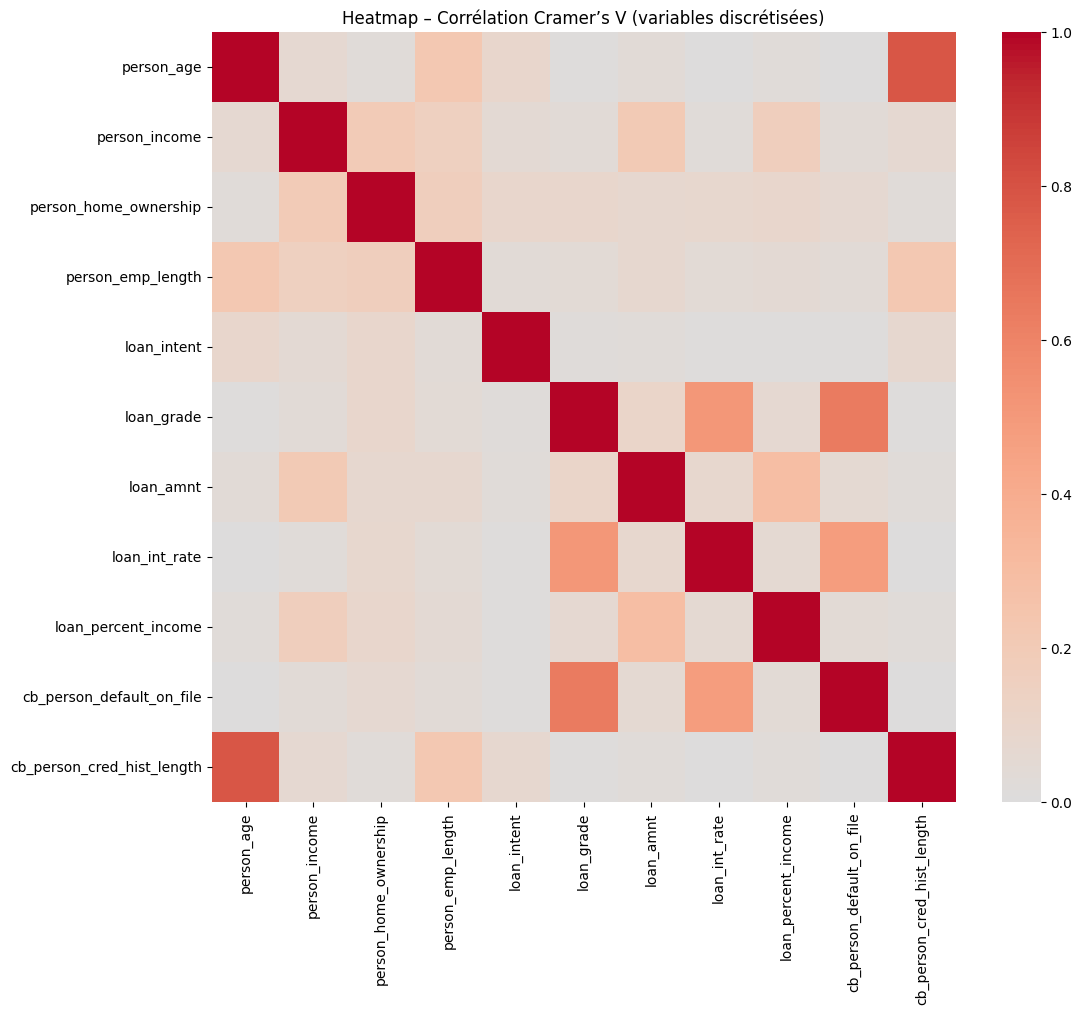

In [12]:
matrix = pd.DataFrame(index=features, columns=features)

for col1 in features:
    for col2 in features:
        matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

matrix = matrix.astype(float)

plt.figure(figsize=(12,10))
sns.heatmap(matrix, annot=False, cmap="coolwarm", center=0)
plt.title("Heatmap – Corrélation Cramer’s V (variables discrétisées)")
plt.show()


### 🖼️ Heatmap Corrélation Post-Discrétisation — Cramer's V

###  Observations générales

- La heatmap montre **visuellement les corrélations entre toutes les variables discrétisées**.  
- Les couleurs plus foncées indiquent une **corrélation plus forte (CramerV proche de 1)**.  
- La diagonale est toujours rouge foncé → corrélation parfaite avec soi-même.

###    corrélations fortes à surveiller

- `cb_person_cred_hist_length ↔ person_age` → très foncé, CramerV ≈ 0.78  
- `cb_person_default_on_file ↔ loan_grade` → foncé, CramerV ≈ 0.63  
- `loan_grade ↔ loan_int_rate` → foncé, CramerV ≈ 0.51  
- `cb_person_default_on_file ↔ loan_int_rate` → modérément foncé, CramerV ≈ 0.48  

Ces couples correspondent aux relations logiques identifiées précédemment avec Chi².

###  Corrélations modérées

- `loan_amnt ↔ loan_percent_income`  
- `loan_amnt ↔ person_income`  
- `person_age ↔ person_emp_length`  

Ces couples sont visibles mais moins intenses que les corrélations principales.

###  Décisions recommandées

- Les variables **fortement corrélées** (foncé / CramerV > 0.5) doivent être **documentées**.  
- Arbitrage à faire pour le modèle : conserver la variable **la plus stable, interprétable et informative**.  
- Les corrélations modérées sont à surveiller mais **pas de suppression systématique**.  
- Les variables faiblement corrélées peuvent être conservées sans risque de multicolinéarité.
